In [1]:
import pandas as pd
import os
from os.path import join
import seaborn as sns
import numpy as np
from coevolve import read_msa
from coevolve.visualization.fig_utils import *
from collections import defaultdict
import matplotlib

In [ ]:
from coevolve.couplings.couplings_vis import construct_monomer_contact_matrix

## Load env variable

In [2]:
from config import RESULTS, FIGURES_DIR
print(RESULTS)
print(FIGURES_DIR)

Project Directory: /data2/isshamie/covid

Config paths:
__name__ config
__package__ 
__file__ /data2/isshamie/covid/notebook/config.py
__cached__ /data2/isshamie/covid/notebook/__pycache__/config.cpython-37.pyc
path /data2/isshamie/covid/notebook/config.py
DATA_DIR /data2/isshamie/covid/data
RESULTS /data2/isshamie/covid/data/processed
FIGURES_DIR /data2/isshamie/covid/figures
FIG_NET_DIR /data2/isshamie/covid/figures/networks
PIPELINE_F /data2/isshamie/covid/reports/pipeline/Pipeline.xlsx
DATA_FIG_DIR /data2/isshamie/covid/data/processed/figures
PARAMS_DIR /data2/isshamie/covid/parameters
TEST_DIR /data2/isshamie/covid/tests
d /data2/isshamie/covid/tests
UNIPROT_MAP /data2/isshamie/covid/data/external/biomart/mart_export_uniprot.txt
GENE_MAP /data2/isshamie/covid/data/external/biomart/mart_export.txt
SECM_ANNO /data2/isshamie/covid/data/external/secretory_annotations/SM_feizi.tsv
SECP_ANNO /data2/isshamie/covid/data/external/secretory_annotations/SP_feizi.tsv
NETWORKS_DIR /data/issham

In [24]:
evc_dir = join(RESULTS,"evc")
col90_red_8_dir = join(evc_dir, "col90_redund0.8")
align_dir = join(col90_red_8_dir,"align")
coupling_dir = join(col90_red_8_dir,"coupling")
contact_dir = join(RESULTS, "contact")
if not os.path.exists(contact_dir):
    os.mkdir(contact_dir)

gene_of_interest = "col90_redund0.8"
align_prefix = os.path.join(evc_dir,gene_of_interest,"align",gene_of_interest)
coupling_prefix = os.path.join(evc_dir, gene_of_interest,"couplings",gene_of_interest)

print(coupling_prefix)
print(align_prefix)

/data2/isshamie/covid/data/processed/evc/col90_redund0.8/couplings/col90_redund0.8
/data2/isshamie/covid/data/processed/evc/col90_redund0.8/align/col90_redund0.8


------

## Part 1: Alignment statistics

For the monomer pipeline, the alignment is found in the align subdirectory of the output folder. For the complexes pipeline, the concatenated alignment is found in the concatenate subdirectory, and the individual monomer alignments are found in the align_1 and align_2 subdirectories. 

### Final alignment file (.a2m)

The final alignment file in [.a2m format](https://compbio.soe.ucsc.edu/a2m-desc.html). This file is used to calculate evolutionary couplings (ECs). Lowercase columns indicate columns with too many gaps that did not meet the minimum column coverage threshold, which means they were excluded from the EC calculation. Lowercase columns have a '.' for gap character by convention. Additionally, sequences which did not fulfill the the minimum sequence coverage threshold (i.e. fragments with too many gaps) have been removed from this alignment. 

*output key: alignment_file*

In [4]:
from evcouplings.align import Alignment

# Load the alignment - format will be detected automatically but can also be set manually
with open(align_prefix +  ".a2m") as f:
    aln = Alignment.from_file(f)

print("Alignment has {} sequences and {} columns".format(aln.N, aln.L))

Alignment has 532 sequences and 1273 columns


### Alignment and EC statistics summary (_job_statistics_summary.csv)

Contains information on properties of the final alignment. This file is only produced if the *evcouplings* application is run (otherwise see alignment_statistics.csv for a truncated version of this file, *output key: statistics_file*).

Columns:
   - prefix: run prefix
   - minimum_column_coverage: user input, fraction of non-gap characters required per column
   - num_seqs: number of sequences in final alignment
   - seqlen: length of target sequence (interchangeably called the query sequence)
   - num_cov: number of uppercase columns in final alignment (columns that satisfied minimumum_column_coverage) 
   - num_lc: number of lowercase columns in final alignment (columns that did not satisfy minimum_column_coverage)
   - perc_cov: fraction of columns that are uppercase (num_cov / seqlen)
   - 1st_uc: index of first uppercase column, numbered according to target sequence
   - last_uc: index of last uppercase column, numbered according to target sequence
   - len_cov: last_uc - 1st_uc
   - num_lc_cov: number of lowercase columns between 1st_uc and last_uc (i.e. num_cov = len_cov - num_lc_cov)
   - N_eff: effective number of non-redundant sequences after clustering based on theta parameter(similar neighborhood = 1 sequence)
   - domain_threshold: sequence search inclusion threshold
   - average_identity: average percent identity of sequences in the alignments to the target sequence
   
The following outputs are only added if the "couplings" and "compare" stages of the pipeline are also run, respectively:
   - num_significant: number of significant ECs (at 90% probabilitity cutoff)
   - precision: precision of the top L significant ECs compared to structure

In [5]:
pd.read_csv(align_prefix+"_alignment_statistics.csv").transpose()

,0
prefix,../data/processed/evc/col90_redund0.8/align/co...
minimum_column_coverage,0.9
num_seqs,532
seqlen,1273
num_cov,1273
num_lc,0
perc_cov,1
1st_uc,1
last_uc,1273
len_cov,1273


### Frequencies file (_frequencies.csv)


Contains the frequency of each character in each position of the alignment. These frequencies are raw, i.e. does not sequence reweighting.

*output key: frequencies_file*

Columns: 
- pos: position in alignment, numbered according to target sequence
- target_seq: character in target sequence
- conservation: column entropy. A value of 1 indicates perfect conservation. A value near zero indicates very little conservation.
- [chars]: the remaining columns are frequency of each character in that position in the alignment


In [6]:
frequencies = pd.read_csv(align_prefix + "_frequencies.csv")
conserved_sequence = frequencies["A_i"].values
frequencies.head()

,i,A_i,conservation,-,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
0,1,M,0.957,0.0,0.0,0.002,0.0,0.0,0.002,0.0,...,0.979,0.004,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.009
1,2,F,0.973,0.0,0.0,0.000,0.0,0.0,0.985,0.0,...,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.013,0.0,0.000
2,3,V,0.960,0.0,0.0,0.013,0.0,0.0,0.004,0.0,...,0.000,0.000,0.0,0.0,0.0,0.002,0.000,0.979,0.0,0.000
3,4,F,0.987,0.0,0.0,0.000,0.0,0.0,0.994,0.0,...,0.000,0.000,0.0,0.0,0.0,0.002,0.000,0.000,0.0,0.000
4,5,L,0.961,0.0,0.0,0.000,0.0,0.0,0.006,0.0,...,0.000,0.000,0.0,0.0,0.0,0.013,0.002,0.000,0.0,0.000


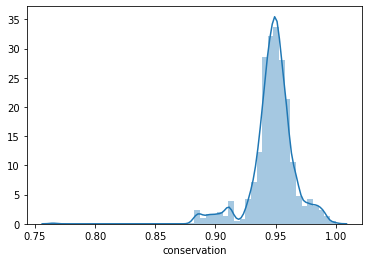

In [7]:
sns.distplot(frequencies["conservation"])

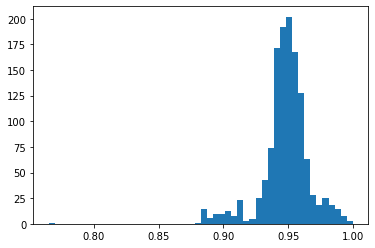

In [30]:
plt.hist(frequencies["conservation"], bins=50)
plt.savefig(join(FIGURES_DIR, "conservation_histogram.png"))
plt.savefig(join(FIGURES_DIR, "conservation_histogram.svg"))

In [37]:
sliding = 10
bin_size = 20
conservation_smooth = []
for i in range(0,frequencies.shape[0], sliding):
    conservation_smooth.append(frequencies["conservation"][i:i+bin_size].mean())
    
conservation_smooth

[0.9660000000000002,
 0.9614999999999998,
 0.9573,
 0.9544500000000001,
 0.9573999999999998,
 0.9618999999999998,
 0.9604999999999999,
 0.9593,
 0.9611000000000001,
 0.96455,
 0.9625,
 0.9601499999999998,
 0.96365,
 0.9605500000000001,
 0.9496500000000001,
 0.9481000000000002,
 0.95055,
 0.9472500000000001,
 0.9383499999999998,
 0.9323499999999999,
 0.9413499999999999,
 0.9473,
 0.9483,
 0.9492499999999999,
 0.9471,
 0.9440499999999998,
 0.9445,
 0.9441999999999998,
 0.9406500000000001,
 0.9447500000000002,
 0.94615,
 0.94115,
 0.9427999999999999,
 0.9455,
 0.9458,
 0.9441499999999999,
 0.9423500000000002,
 0.9432500000000001,
 0.9451,
 0.9468,
 0.9474499999999999,
 0.9517000000000001,
 0.94235,
 0.91325,
 0.9036,
 0.9103000000000001,
 0.9042499999999999,
 0.9005000000000001,
 0.89985,
 0.8983000000000001,
 0.90055,
 0.908,
 0.9342499999999999,
 0.95855,
 0.9594499999999998,
 0.9574499999999999,
 0.95845,
 0.9606000000000003,
 0.9609500000000001,
 0.9588000000000001,
 0.949900000000000

Text(0.5, 1.0, 'Conservatin over every 20 amino acids with sliding window of 10')

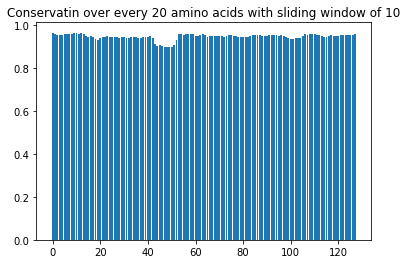

In [40]:
plt.bar(range(len(conservation_smooth)), conservation_smooth)
plt.title(f"Conservatin over every {bin_size} amino acids with sliding window of {sliding}")

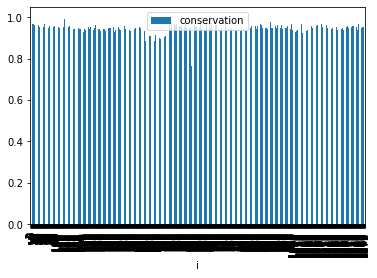

In [8]:
frequencies.plot.bar(x="i", y = "conservation")

### Identities file (_identities.csv)

Contains the sequence identity of each sequence in the alignment to the target sequence. 

*output key: identities_file*

columns:
- id: sequence identifier
- identity_to_query: fraction of sequence identity to the target sequence. 

In [11]:
ids = pd.read_csv(os.path.join(align_prefix + "_identities.csv"))
ids.head()

,id,identity_to_query
0,hCoV_19ChileTalca_22020_EPI_ISL_414578_2020_03_04,1.000
1,hCoV_19ChinaWF00092020_EPI_ISL_413696_2020_01,0.148
2,hCoV_19NetherlandsZuidHolland_232020_EPI_ISL_4...,0.077
3,hCoV_19ChinaWF00172020_EPI_ISL_413747_2020_02,0.268
4,hCoV_19pangolinGuangdong12019_EPI_ISL_410721_2019,0.104


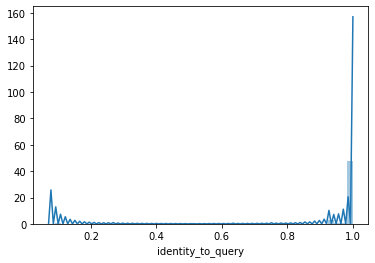

In [12]:
sns.distplot(ids["identity_to_query"])

Text(0.5, 1.0, 'Identity to query (randomly chosen representative)')

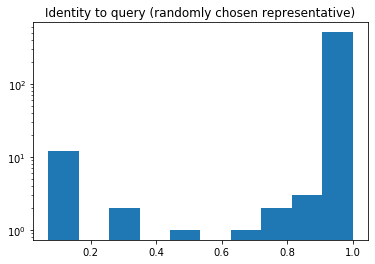

In [43]:
plt.hist(ids["identity_to_query"], log=True)
plt.title("Identity to query (randomly chosen representative)")


------

## Part 2: Coupling scores and comparison to structure

### Raw evolutionary couplings file (_ECs.txt)

### Coupling Scores File (_CouplingScores.csv)

Contains the evolutionary couplings sorted according to score, and the probability that a pair represents significant coupling rather than background noise (probability of belonging to the lognormal component of a lognormal (signal) - skew normal (noise) mixture model).

Note: this file contains couplings between positions that are close on the chain, which are known to be high due to short-range contacts in the molecule. You may want to filter these before further analysis. 

*output key: ec_file*

Columns:
- i: position i, numbered according to target sequence
- A_i: character in position i in target sequence
- Segment_i: (complexes only) specifies whether position i originates from the first monomer (A_1) or the second monomer (B_1). Position i is numbered according to its position _within_ the monomer sequence, not its overall position in the concatenated alignment. 
- j: position j, numbered according to target sequence
- A_j: character in position j in target sequence
- Segment_j: (complexes only) specifies whether position j originates from the first monomer (A_1) or the second monomer (B_1). Position j is numbered according to its position _within_ the monomer sequence, not its overall position in the concatenated alignment. 
- fn: placeholder column (formerly fn score)
- cn: Evolutionary couplings score (cn score)
- probability: Probability that this coupling is significant (i.e. in the lognormal signal tail)

In [28]:
scores = pd.read_csv(coupling_prefix +"_CouplingScores.csv")
scores
#scores = pd.concat((scores,scores.copy().rename({"i": "j_"},axis=1).rename({"j":"i"},axis=1).rename({"j_":"j"},axis=1)),axis=0)



,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
0,416,G,417,K,0,0.005785,A,A,0.999281
1,417,K,419,A,0,0.005581,A,A,0.998514
2,417,K,427,D,0,0.005482,A,A,0.997924
3,410,I,417,K,0,0.005469,A,A,0.997833
4,413,G,417,K,0,0.005393,A,A,0.997223
5,417,K,421,Y,0,0.005393,A,A,0.997223
6,414,Q,417,K,0,0.005391,A,A,0.997205
7,417,K,424,K,0,0.005391,A,A,0.997205
8,1221,I,1243,C,0,0.005160,A,A,0.994302
9,415,T,417,K,0,0.005147,A,A,0.994079


### Cumulative coupling score file (_enrichment.csv)

Measures the how strongly individual residues are coupled by summing the coupling scores of pairs involving this residues, and then normalizing with the average level of coupling (i.e. enrichment of coupling on this residue relative to background). Highly enriched residues may indicate functionally important residues. Uses the top L ECs for calculation by default. 

*output key: enrichment_file*

Columns:
- i: position i
- A_i: character i
- enrichment: Sum of the evolutionary coupling scores that involve this residue, normalized by the background level of coupling

,i,A_i,enrichment
0,1243,C,48.861463
1,1221,I,47.995050
2,212,L,44.959047
3,360,N,36.848481
4,588,T,35.614036
5,542,N,35.451181
6,904,Y,35.415970
7,842,G,33.783361
8,1216,I,28.553730
9,927,F,27.540375


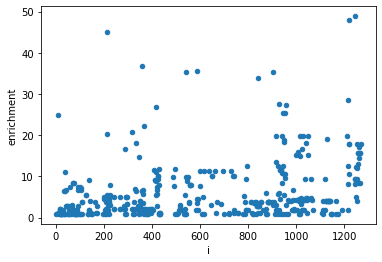

In [18]:
enrich = pd.read_csv(coupling_prefix+"_enrichment.csv")

enrich.plot.scatter(x="i",y="enrichment")
enrich

## Take the top enriched sites and plot their amino acids

In [53]:
p_01 = scores[(scores["probability"] > 0.99)]
sites = p_01[""]
p_01

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability,Bonf
0,416,G,417,K,0,0.005785,A,A,0.999281,582.491260
1,417,K,419,A,0,0.005581,A,A,0.998514,1202.889435
2,417,K,427,D,0,0.005482,A,A,0.997924,1680.722831
3,410,I,417,K,0,0.005469,A,A,0.997833,1754.713073
4,413,G,417,K,0,0.005393,A,A,0.997223,2248.492960
5,417,K,421,Y,0,0.005393,A,A,0.997223,2248.492960
6,414,Q,417,K,0,0.005391,A,A,0.997205,2263.008989
7,417,K,424,K,0,0.005391,A,A,0.997205,2263.008989
8,1221,I,1243,C,0,0.005160,A,A,0.994302,4613.609886
9,415,T,417,K,0,0.005147,A,A,0.994079,4793.585305


In [54]:
p_05 = scores[(scores["probability"] > 0.95)]
p_05

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability,Bonf
0,416,G,417,K,0,0.005785,A,A,0.999281,582.491260
1,417,K,419,A,0,0.005581,A,A,0.998514,1202.889435
2,417,K,427,D,0,0.005482,A,A,0.997924,1680.722831
3,410,I,417,K,0,0.005469,A,A,0.997833,1754.713073
4,413,G,417,K,0,0.005393,A,A,0.997223,2248.492960
5,417,K,421,Y,0,0.005393,A,A,0.997223,2248.492960
6,414,Q,417,K,0,0.005391,A,A,0.997205,2263.008989
7,417,K,424,K,0,0.005391,A,A,0.997205,2263.008989
8,1221,I,1243,C,0,0.005160,A,A,0.994302,4613.609886
9,415,T,417,K,0,0.005147,A,A,0.994079,4793.585305


## Plot the significant (p< 0.05 scores) pairings

/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('G', 'K'): 518, ('X', 'X'): 1, ('L', 'L'): 3, ('C', 'L'): 9, ('-', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'A'): 518, ('X', 'X'): 1, ('L', 'I'): 6, ('L', 'T'): 1, ('L', 'A'): 5, ('-', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'D'): 518, ('X', 'X'): 1, ('L', 'L'): 5, ('L', 'N'): 1, ('L', 'Y'): 5, ('-', '-'): 1, ('L', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('I', 'K'): 514, ('G', 'K'): 2, ('X', 'X'): 1, ('S', 'L'): 7, ('R', 'L'): 5, ('S', '-'): 1, ('X', 'K'): 2})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('G', 'K'): 516, ('X', 'X'): 1, ('L', 'L'): 2, ('R', 'L'): 1, ('W', 'L'): 8, ('S', '-'): 1, ('X', 'K'): 2, ('Q', 'L'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'Y'): 518, ('X', 'X'): 1, ('L', 'I'): 3, ('L', 'F'): 1, ('L', 'R'): 8, ('-', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('Q', 'K'): 518, ('X', 'X'): 1, ('E', 'L'): 3, ('K', 'L'): 4, ('C', 'L'): 5, ('L', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'K'): 518, ('X', 'X'): 1, ('L', 'Q'): 2, ('L', 'R'): 4, ('L', 'W'): 5, ('-', '-'): 1, ('L', 'L'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('I', 'C'): 516, ('F', 'S'): 11, ('I', 'P'): 1, ('H', '-'): 1, ('I', 'X'): 2, ('-', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('T', 'K'): 518, ('X', 'X'): 1, ('R', 'L'): 2, ('N', 'L'): 1, ('Y', 'L'): 5, ('D', 'L'): 3, ('-', '-'): 1, ('E', 'L'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'D'): 518, ('X', 'X'): 1, ('L', 'I'): 3, ('L', 'P'): 1, ('L', 'A'): 5, ('L', 'T'): 3, ('-', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'P'): 518, ('X', 'X'): 1, ('L', 'I'): 3, ('L', '-'): 4, ('L', 'C'): 5, ('-', '-'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('I', 'A'): 514, ('G', 'A'): 2, ('X', 'X'): 1, ('S', 'I'): 6, ('S', 'T'): 1, ('R', 'A'): 5, ('S', '-'): 1, ('X', 'A'): 2})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('K', 'G'): 516, ('K', '-'): 1, ('X', 'X'): 1, ('L', 'L'): 10, ('L', '-'): 1, ('-', '-'): 1, ('K', 'X'): 1, ('L', 'V'): 1})


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


defaultdict(<class 'int'>, {('G', 'Y'): 516, ('X', 'X'): 1, ('L', 'I'): 2, ('R', 'F'): 1, ('W', 'R'): 8, ('S', '-'): 1, ('X', 'Y'): 2, ('Q', 'I'): 1})


,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability,Bonf
0,416,G,417,K,0,0.005785,A,A,0.999281,582.491260
1,417,K,419,A,0,0.005581,A,A,0.998514,1202.889435
2,417,K,427,D,0,0.005482,A,A,0.997924,1680.722831
3,410,I,417,K,0,0.005469,A,A,0.997833,1754.713073
4,413,G,417,K,0,0.005393,A,A,0.997223,2248.492960
5,417,K,421,Y,0,0.005393,A,A,0.997223,2248.492960
6,414,Q,417,K,0,0.005391,A,A,0.997205,2263.008989
7,417,K,424,K,0,0.005391,A,A,0.997205,2263.008989
8,1221,I,1243,C,0,0.005160,A,A,0.994302,4613.609886
9,415,T,417,K,0,0.005147,A,A,0.994079,4793.585305


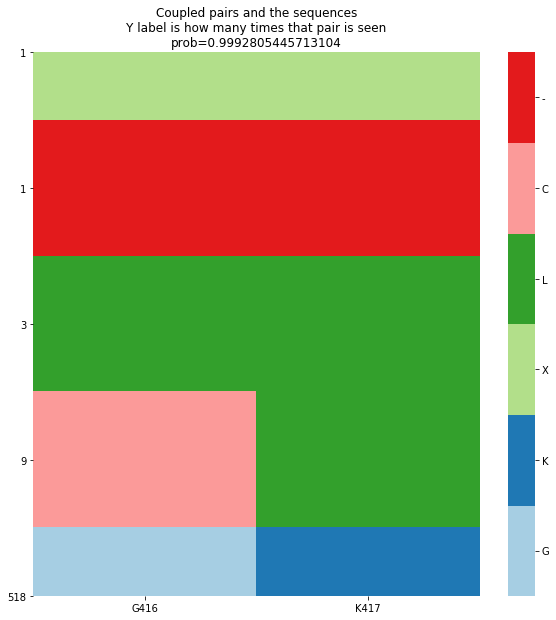

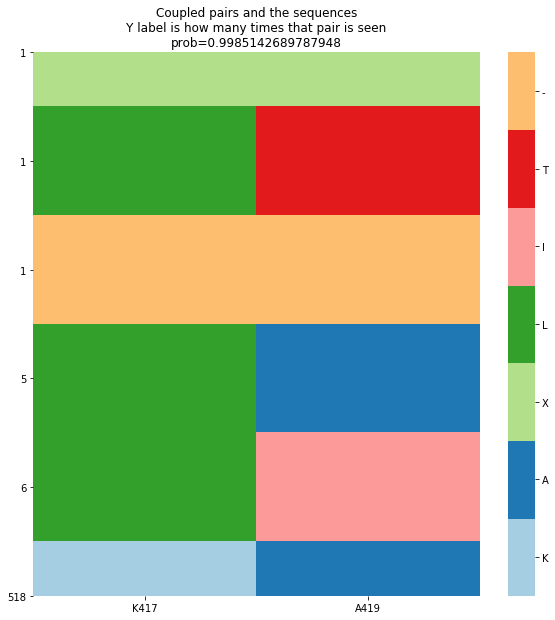

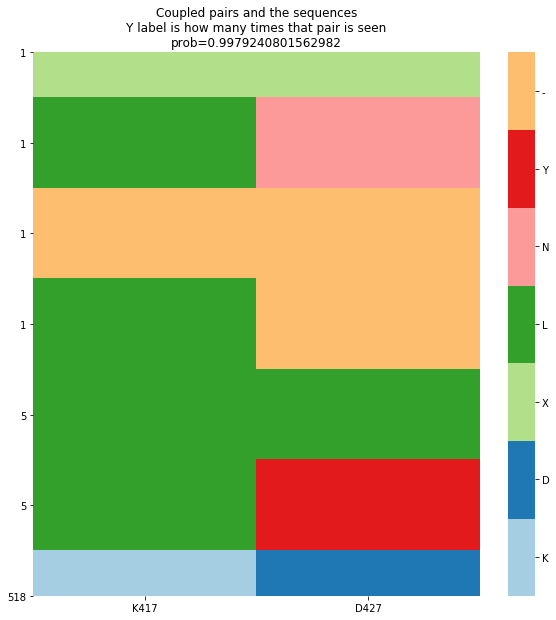

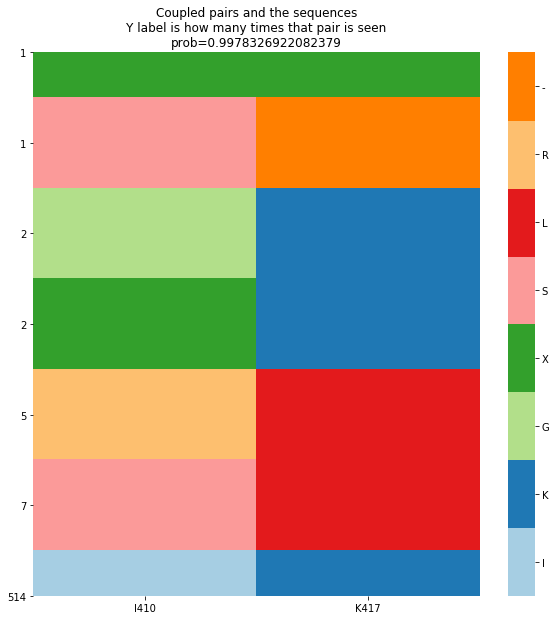

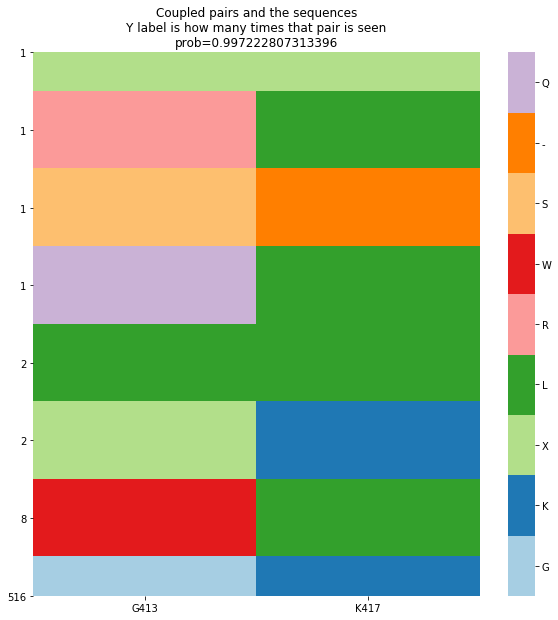

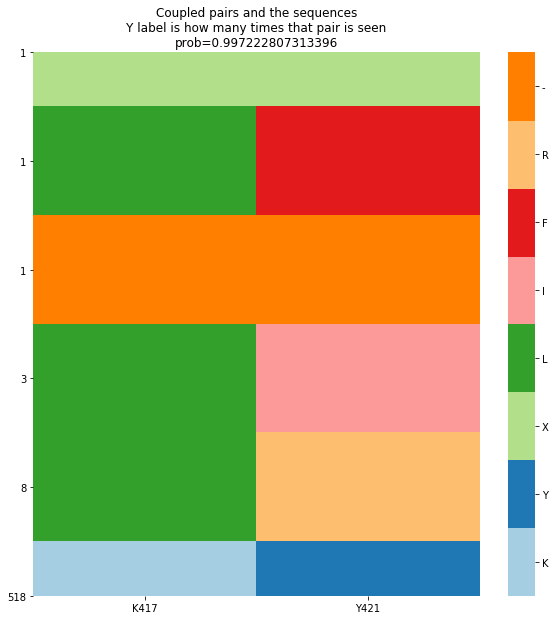

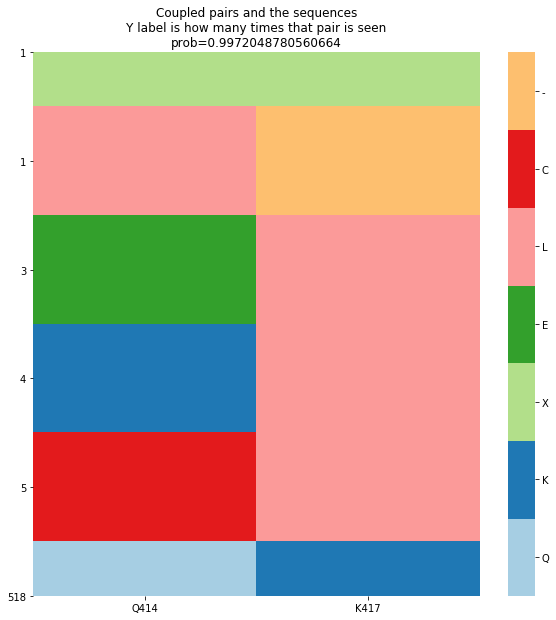

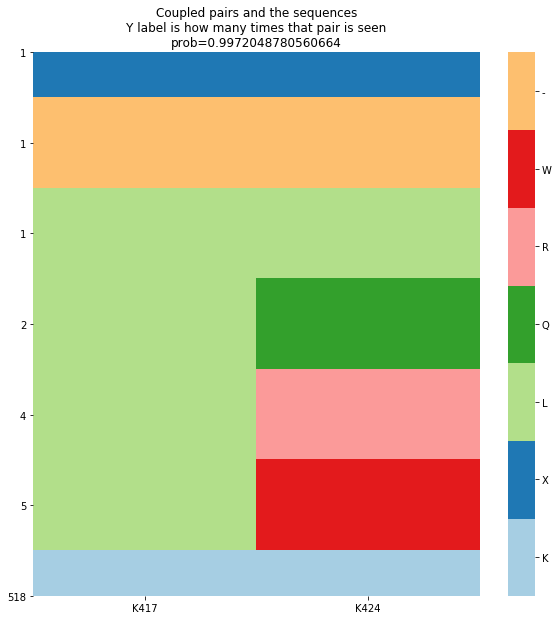

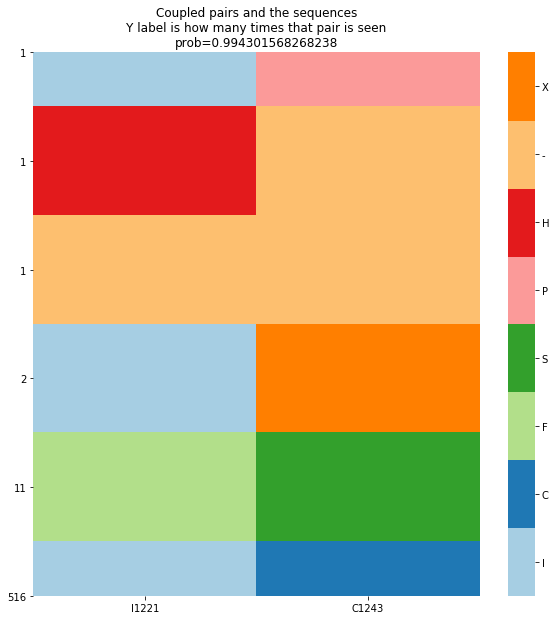

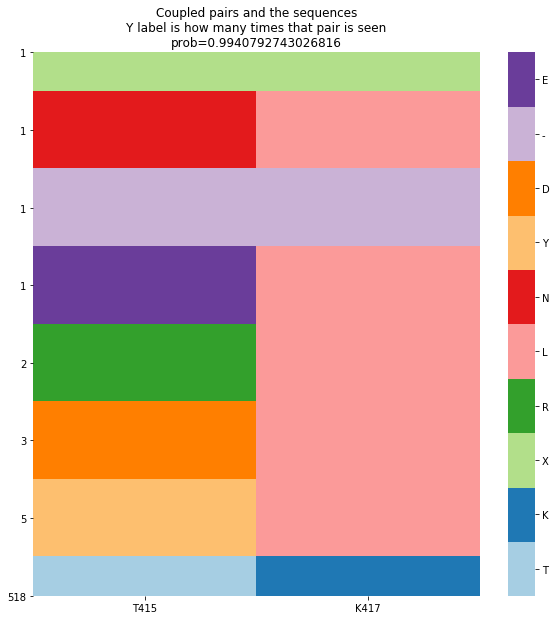

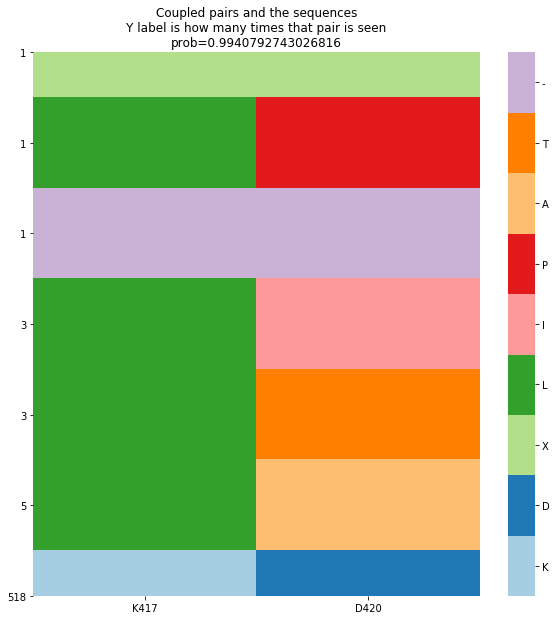

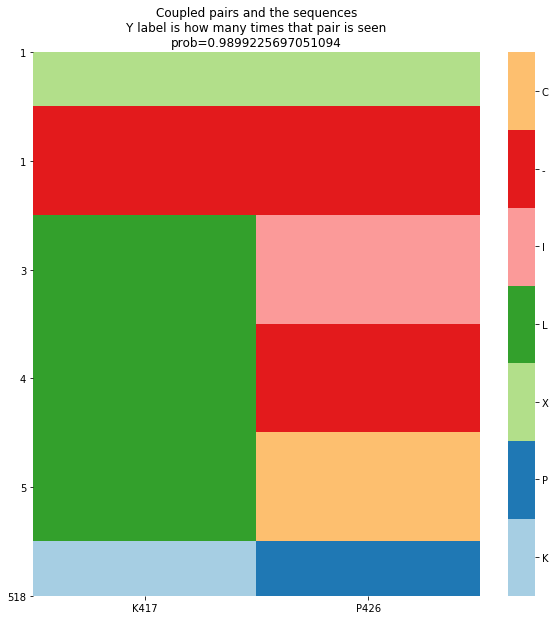

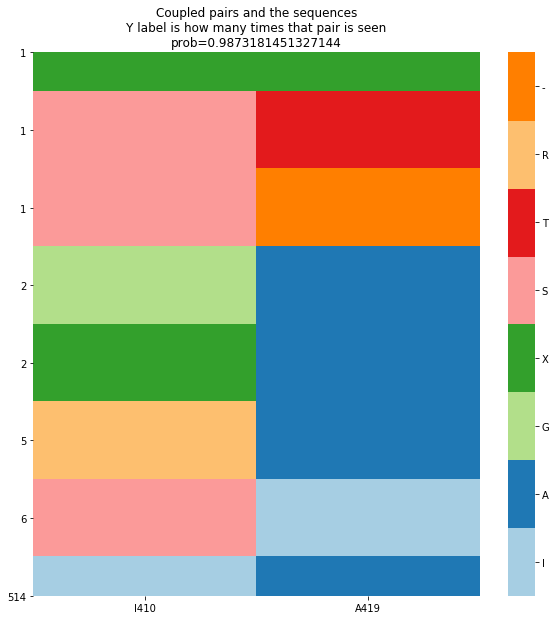

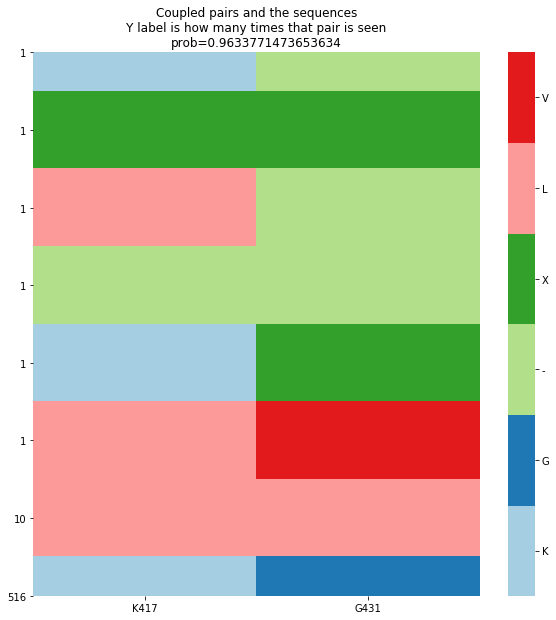

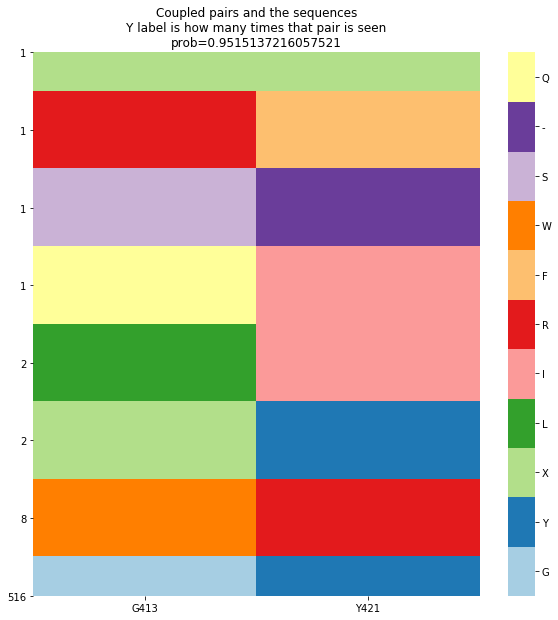

In [55]:
# df = scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites)) &
#             (scores["probability"]>0.7)]
df = p_05

seqs_msa_a2m = read_msa(os.path.join(align_prefix+".a2m"))


#def pair_conservation_heat(df):
for ind, val in df.iterrows():
    curr_seqs = seqs_msa_a2m[:,[val["i"]-1, val["j"]-1]]
    
    value_to_int = {j:i for i,j in enumerate(pd.unique(curr_seqs.ravel()))} # like you did
    n = len(value_to_int)
    # discrete colormap (n samples from a given cmap)
    if n > 12:
        cmap = sns.color_palette("Paired", 12) + sns.color_palette("cubehelix", n-12)
    else:
        #cmap = sns.color_palette("Pastel2", n)
        cmap = sns.color_palette("Paired", n)

    d = defaultdict(int)
    for i in curr_seqs:
        d[tuple(i)] += 1
        
    i_max = frequencies[frequencies["i"] == val["i"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].argmax()
    j_max = frequencies[frequencies["i"] == val["j"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].argmax()  

    curr_df = pd.DataFrame(d.keys(), index=d.values(), columns=(i_max + str(val["i"]), j_max
                                                                + str(val["j"])))
    print(d)
    f, ax = plt.subplots(1,1, figsize=(10,10))

    sns.heatmap(curr_df.replace(value_to_int).sort_index(), cmap=cmap,ax=ax, yticklabels=True ) 
    #plt.xticks(rotation='vertical')
    ax.tick_params(axis='y',which='major', labelrotation=0)
    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))       
    plt.title(f"Coupled pairs and the sequences\nY label is how many times that pair is seen\nprob={val['probability']}")
    plt.savefig(os.path.join(FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".png")
    plt.savefig(os.path.join(FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".pdf")
    #break
df


## Construct contact matrix

### With cn

In [26]:
# construct_monomer_contact_matrix(gene_of_interest, 
#                                  input_dir = evc_dir, 
#                                  to_plot=True, 
#                                  f_save_fig = join(FIGURES_DIR, "contact", gene_of_interest),
#                                  f_save = join(contact_dir, gene_of_interest), 
#                                  col='cn', conservation=True) 

/data2/isshamie/covid/data/processed/evc/col90_redund0.8/align/col90_redund0.8*frequencies.csv


,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
1,0.0,0.001568,0.002307,0.000958,0.002307,0.002307,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
2,0.0,0.000000,0.001568,-0.000208,0.001568,0.001568,0.001769,-0.000204,0.001562,0.001492,...,-0.000543,0.000435,-0.000543,0.000131,-0.000543,-0.000468,-0.000468,-0.000468,-0.000468,-0.000468
3,0.0,0.000000,0.000000,0.000958,0.002307,0.002307,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
4,0.0,0.000000,0.000000,0.000000,0.000958,0.000958,0.001059,0.001930,0.000976,0.000018,...,-0.000142,-0.000302,-0.000142,0.000296,-0.000142,-0.000300,-0.000300,-0.000300,-0.000300,-0.000300
5,0.0,0.000000,0.000000,0.000000,0.000000,0.002307,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002839,0.000960,0.002567,0.001079,...,-0.000499,0.000112,-0.000499,-0.000267,-0.000499,-0.000325,-0.000325,-0.000325,-0.000325,-0.000325
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001058,0.003200,0.001493,...,-0.000269,-0.000333,-0.000269,0.000384,-0.000269,0.000190,0.000190,0.000190,0.000190,0.000190
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000976,0.000020,...,-0.000145,-0.000302,-0.000145,0.000295,-0.000145,-0.000302,-0.000302,-0.000302,-0.000302,-0.000302
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001360,...,-0.000452,0.000433,-0.000452,0.000097,-0.000452,-0.000083,-0.000083,-0.000083,-0.000083,-0.000083
10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000318,0.000972,-0.000318,0.000164,-0.000318,-0.000317,-0.000317,-0.000317,-0.000317,-0.000317


### With probability 

In [27]:
# construct_monomer_contact_matrix(gene_of_interest, 
#                                  input_dir = evc_dir, 
#                                  to_plot=True, 
#                                  f_save_fig = join(FIGURES_DIR, "contact", gene_of_interest+"_pval"),
#                                  f_save = join(contact_dir, gene_of_interest+"_pval"), 
#                                  col='probability', conservation=True) 

/data2/isshamie/covid/data/processed/evc/col90_redund0.8/align/col90_redund0.8*frequencies.csv


,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
1,0.0,0.106677,0.481207,0.000802,0.481207,0.481207,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.0,0.000000,0.106677,0.000000,0.106677,0.106677,0.206065,0.000000,0.104114,7.655791e-02,...,0.000000,1.393567e-10,0.000000,1.519397e-29,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,0.000000,0.000000,0.000802,0.481207,0.481207,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,0.000000,0.000000,0.000000,0.000802,0.000802,0.002890,0.294405,0.001029,9.305682e-85,...,0.000000,0.000000e+00,0.000000,1.698589e-15,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,0.0,0.000000,0.000000,0.000000,0.000000,0.481207,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.668868,0.000825,0.582201,3.611977e-03,...,0.000000,8.091154e-33,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002857,0.764545,7.691977e-02,...,0.000000,0.000000e+00,0.000000,4.695053e-12,0.000000,1.615808e-22,1.615808e-22,1.615808e-22,1.615808e-22,1.615808e-22
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001029,4.475446e-81,...,0.000000,0.000000e+00,0.000000,1.520697e-15,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.742110e-02,...,0.000000,1.235183e-10,0.000000,5.504890e-36,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,9.739901e-04,0.000000,3.564153e-25,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### To run the server for EVZoom, go to the folder (currently /home/isshamie/software/EVzoom) and type
`python -m http.server 8000` for python3  
or `python -m SimpleHTTPServer 8000` for python2  
https://github.com/debbiemarkslab/EVzoom

then navigate to http://jabba.ucsd.edu:8000/example/covid_S.html

## TO DO: ADD THE GLYCOSITES

#### Are any of the site pairs with a glycosylation site with high coupling relative to other glycosylation sites? Relative to other sites in general?

In [56]:
glycosites = np.array([17,61,74,122,149,165,234,282,331,343,603,616,717,801,1098,1134,1194])

In [61]:
frequencies = frequencies.set_index("i",drop=False)

In [66]:
print(frequencies.loc[glycosites,"A_i"].values)
print(frequencies.loc[glycosites-1,"A_i"].values)
print(frequencies.loc[glycosites+1,"A_i"].values)
print(frequencies.loc[glycosites+2,"A_i"].values)

frequencies[frequencies["i"].isin(glycosites)]

['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
['V' 'S' 'T' 'N' 'N' 'N' 'I' 'E' 'P' 'F' 'T' 'V' 'T' 'F' 'S' 'V' 'L']
['L' 'V' 'G' 'A' 'K' 'C' 'I' 'G' 'I' 'A' 'T' 'C' 'F' 'F' 'G' 'N' 'E']
['T' 'T' 'T' 'T' 'S' 'T' 'T' 'T' 'T' 'T' 'S' 'T' 'T' 'S' 'T' 'T' 'S']


,i,A_i,conservation,-,A,C,D,E,F,G,...,M,N,P,Q,R,S,T,V,W,Y
i,,,,,,,,,,,,,,,,,,,,,
17,17,N,0.962,0.000,0.000,0.015,0.000,0.0,0.000,0.0,...,0.0,0.979,0.000,0.004,0.000,0.000,0.000,0.002,0.000,0.000
61,61,N,0.954,0.013,0.000,0.006,0.000,0.0,0.000,0.0,...,0.0,0.976,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000
74,74,N,0.959,0.004,0.000,0.000,0.017,0.0,0.000,0.0,...,0.0,0.977,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000
122,122,N,0.974,0.009,0.000,0.000,0.000,0.0,0.000,0.0,...,0.0,0.987,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000
149,149,N,0.952,0.004,0.000,0.000,0.000,0.0,0.002,0.0,...,0.0,0.976,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.002
165,165,N,0.945,0.009,0.002,0.002,0.000,0.0,0.000,0.0,...,0.0,0.972,0.009,0.000,0.000,0.006,0.000,0.000,0.000,0.000
234,234,N,0.954,0.032,0.000,0.000,0.000,0.0,0.000,0.0,...,0.0,0.968,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
282,282,N,0.943,0.023,0.000,0.000,0.000,0.0,0.000,0.0,...,0.0,0.966,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000
331,331,N,0.954,0.032,0.000,0.000,0.000,0.0,0.000,0.0,...,0.0,0.968,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [67]:
scores[(scores["i"].isin(glycosites)) | (scores["j"].isin(glycosites))]

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability,Bonf
377,7,L,17,N,0,0.003115,A,A,0.743576,207607.983930
394,212,L,343,N,0,0.003087,A,A,0.736474,213358.123274
406,73,T,74,N,0,0.003052,A,A,0.727456,220659.557377
407,72,G,74,N,0,0.003052,A,A,0.727456,220659.557377
473,74,N,418,I,0,0.003011,A,A,0.716687,229378.358995
527,74,N,332,I,0,0.002989,A,A,0.710814,234132.855897
653,343,N,360,N,0,0.002912,A,A,0.689715,251215.151855
694,611,L,616,N,0,0.002885,A,A,0.682105,257376.584865
705,1134,N,1216,I,0,0.002879,A,A,0.680398,258758.498520
715,959,L,1134,N,0,0.002879,A,A,0.680398,258758.498520


## Plot the glycosites coupling across positions

Position 17
Position 61
Position 74
Position 122
Position 149
Position 165
Position 234
Position 282
Position 331
Position 343
Position 603
Position 616
Position 717
Position 801
Position 1098
Position 1134
Position 1194


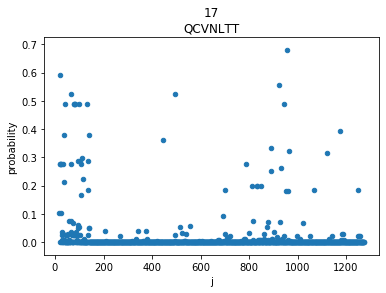

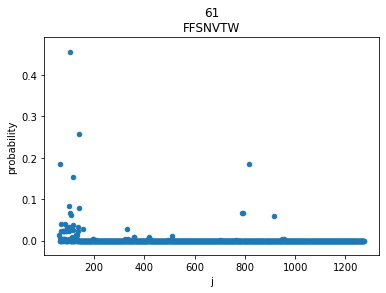

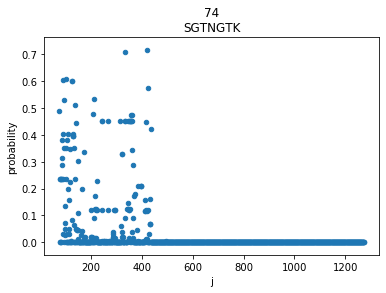

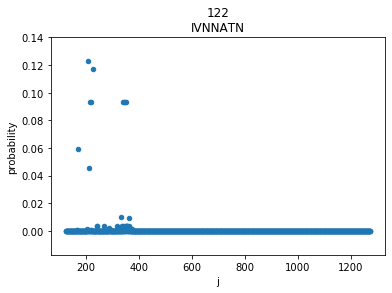

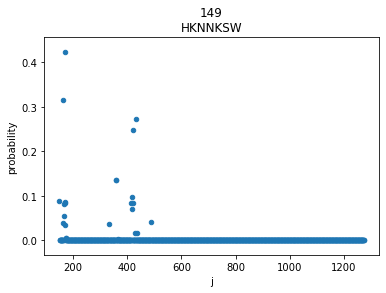

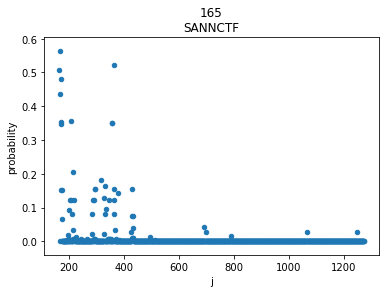

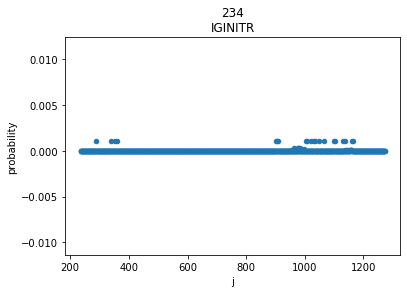

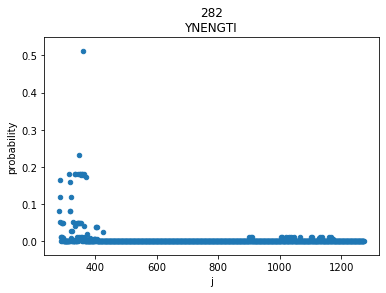

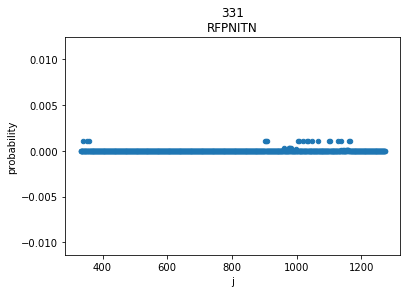

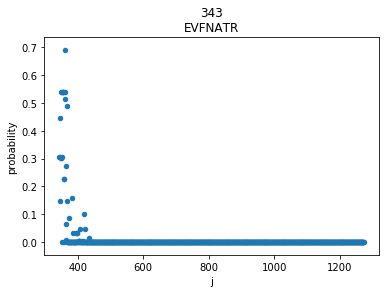

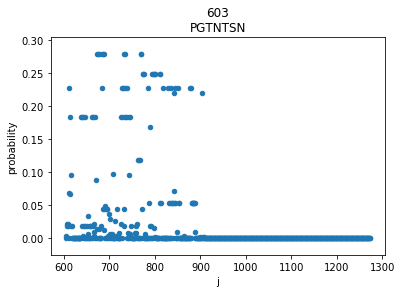

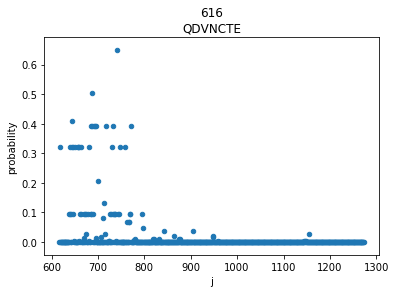

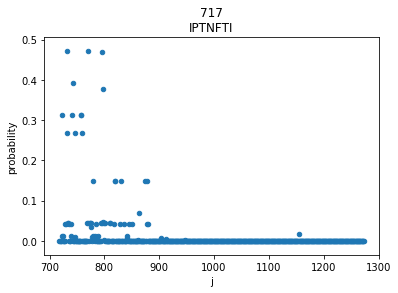

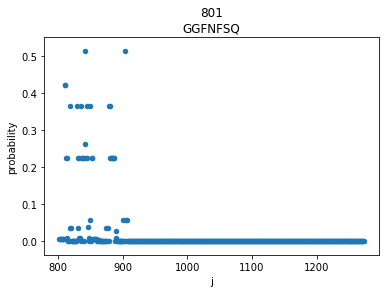

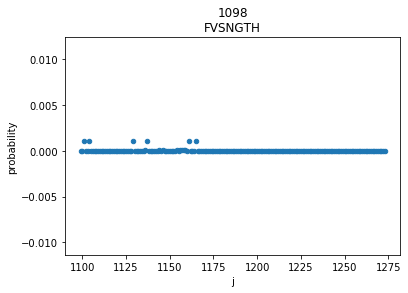

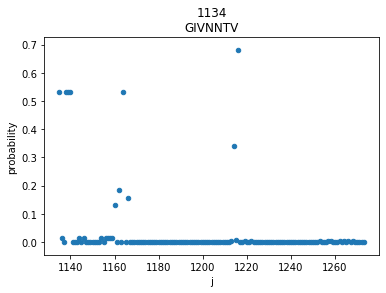

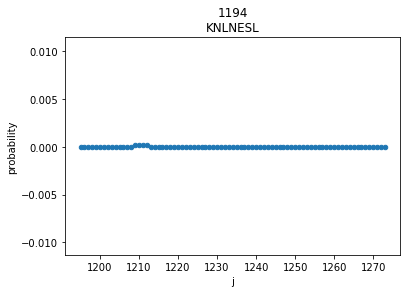

In [68]:
for ind,val in scores[scores["i"].isin(glycosites)].groupby("i"):
    print("Position", val["i"].values[0])
    val.plot.scatter("j","probability")
    title = "".join(conserved_sequence[int(ind)-1-3 : int(ind)-1+4])
    plt.title(str(ind) + "\n" + title)

## Add in adjacent sites (+/- 3 aa)

In [70]:
adj_sites = []
for i in glycosites:
    adj_sites += list(range(i-3, i+3))
adj_sites = set(adj_sites)
adj_sites

{14,
 15,
 16,
 17,
 18,
 19,
 58,
 59,
 60,
 61,
 62,
 63,
 71,
 72,
 73,
 74,
 75,
 76,
 119,
 120,
 121,
 122,
 123,
 124,
 146,
 147,
 148,
 149,
 150,
 151,
 162,
 163,
 164,
 165,
 166,
 167,
 231,
 232,
 233,
 234,
 235,
 236,
 279,
 280,
 281,
 282,
 283,
 284,
 328,
 329,
 330,
 331,
 332,
 333,
 340,
 341,
 342,
 343,
 344,
 345,
 600,
 601,
 602,
 603,
 604,
 605,
 613,
 614,
 615,
 616,
 617,
 618,
 714,
 715,
 716,
 717,
 718,
 719,
 798,
 799,
 800,
 801,
 802,
 803,
 1095,
 1096,
 1097,
 1098,
 1099,
 1100,
 1131,
 1132,
 1133,
 1134,
 1135,
 1136,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196}

In [71]:
print("Number of contacts with probability greater than 0.9 when both residues are adj_sites: ", (scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites))]["probability"]>0.9).sum())
print("Number of contacts with probability greater than 0.9 when either residues is a adj_sites: ",(scores[(scores["i"].isin(adj_sites)) | (scores["j"].isin(adj_sites))]["probability"]>0.9).sum())


Number of contacts with probability greater than 0.9 when both residues are adj_sites:  0
Number of contacts with probability greater than 0.9 when either residues is a adj_sites:  0


In [74]:
print("Number of contacts with probability greater than 0.7 when both residues are adj_sites: ", (scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites))]["probability"]>0.7).sum())
print("Number of contacts with probability greater than 0.7 when either residues is a adj_sites: ",(scores[(scores["i"].isin(adj_sites)) | (scores["j"].isin(adj_sites))]["probability"]>0.7).sum())


Number of contacts with probability greater than 0.7 when both residues are adj_sites:  7
Number of contacts with probability greater than 0.7 when either residues is a adj_sites:  41


In [75]:
scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites))]

,i,A_i,j,A_j,fn,cn,segment_i,segment_j,probability
149,600,P,617,C,0,0.003379,A,A,0.805893
405,72,G,73,T,0,0.003052,A,A,0.727456
406,73,T,74,N,0,0.003052,A,A,0.727456
407,72,G,74,N,0,0.003052,A,A,0.727456
526,73,T,332,I,0,0.002989,A,A,0.710814
527,74,N,332,I,0,0.002989,A,A,0.710814
528,72,G,332,I,0,0.002989,A,A,0.710814
750,16,V,17,N,0,0.002875,A,A,0.679257
1098,124,T,332,I,0,0.002719,A,A,0.632561
1354,72,G,124,T,0,0.002624,A,A,0.601727


Position 14
Position 15
Position 16
Position 17
Position 18
Position 19
Position 58
Position 59
Position 60
Position 61
Position 62
Position 63
Position 71
Position 72
Position 73
Position 74
Position 75
Position 76
Position 119
Position 120
Position 121
Position 122


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if self.logx is True or self.loglog is True:


Position 123
Position 124
Position 146
Position 147
Position 148
Position 149
Position 150
Position 151
Position 162
Position 163
Position 164
Position 165
Position 166
Position 167
Position 231
Position 232
Position 233
Position 234
Position 235
Position 236
Position 279
Position 280
Position 281
Position 282
Position 283
Position 284
Position 328
Position 329
Position 330
Position 331
Position 332
Position 333
Position 340
Position 341
Position 342
Position 343
Position 344
Position 345
Position 600
Position 601
Position 602
Position 603
Position 604
Position 605
Position 613
Position 614
Position 615
Position 616
Position 617
Position 618
Position 714
Position 715
Position 716
Position 717
Position 718
Position 719
Position 798
Position 799
Position 800
Position 801
Position 802
Position 803
Position 1095
Position 1096
Position 1097
Position 1098
Position 1099
Position 1100
Position 1131
Position 1132
Position 1133
Position 1134
Position 1135
Position 1136
Position 1191
Position 119

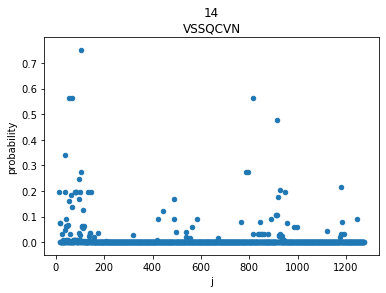

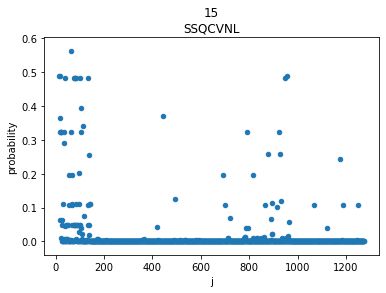

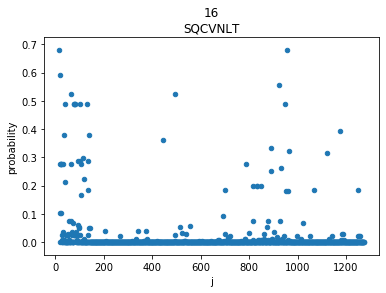

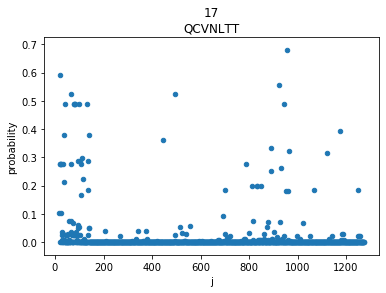

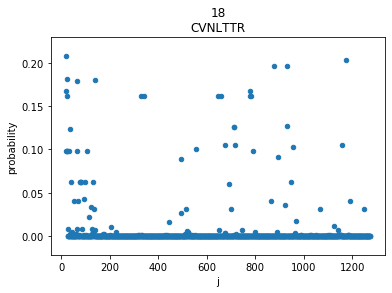

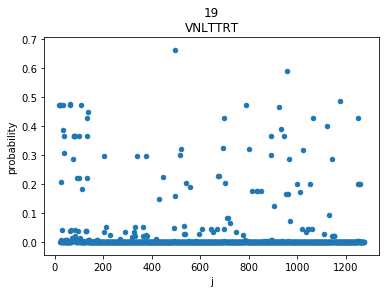

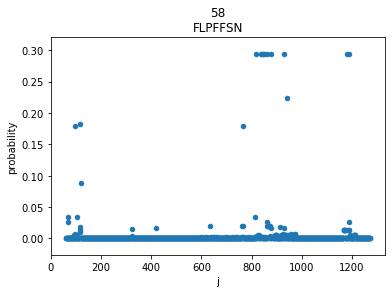

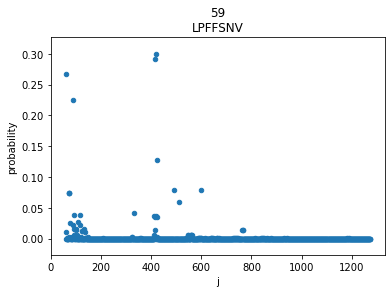

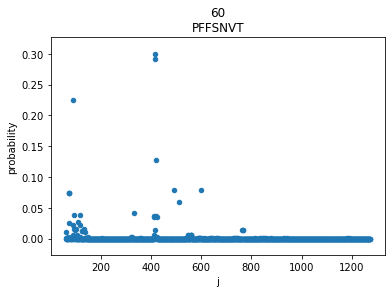

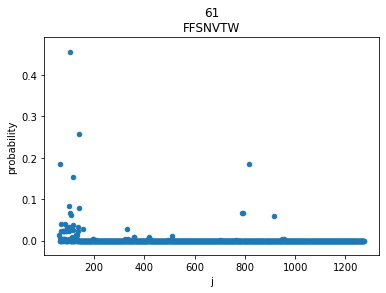

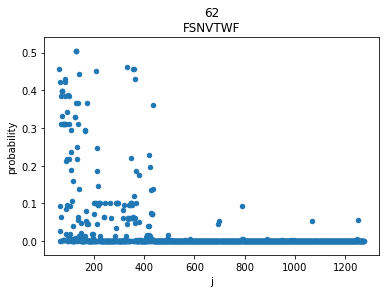

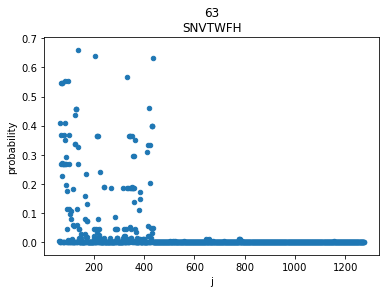

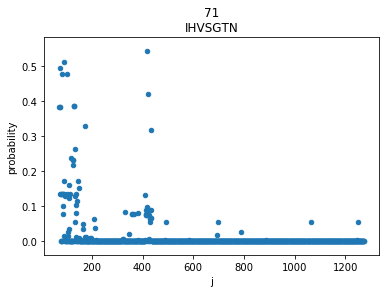

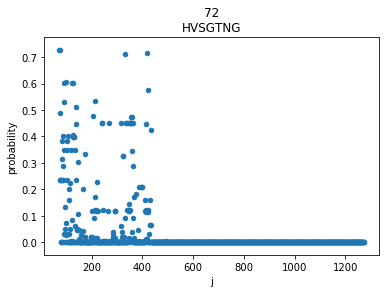

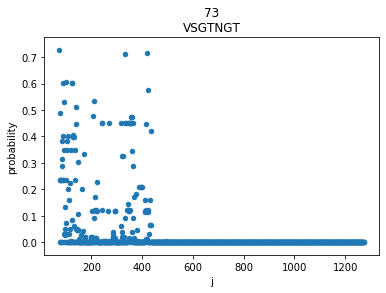

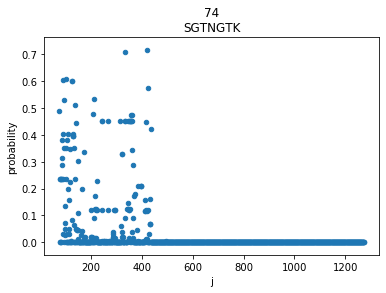

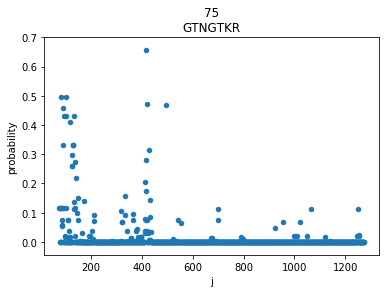

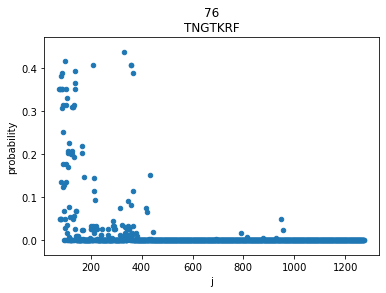

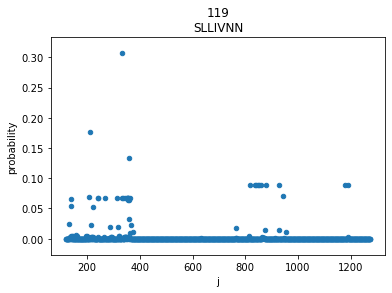

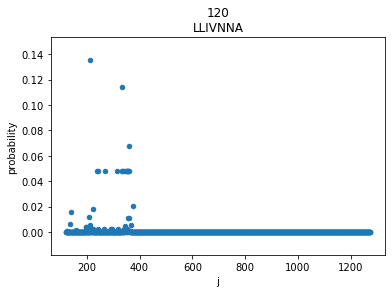

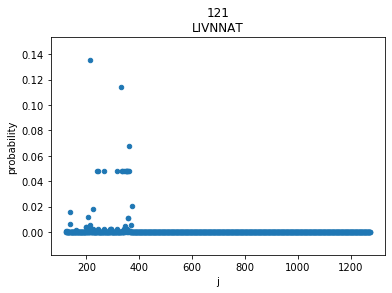

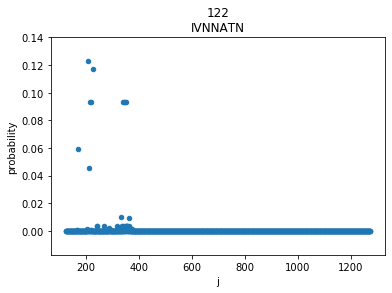

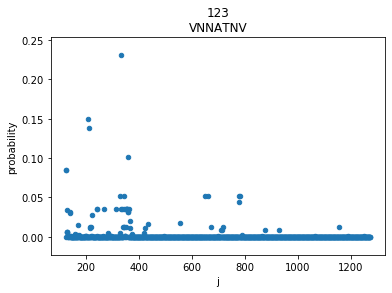

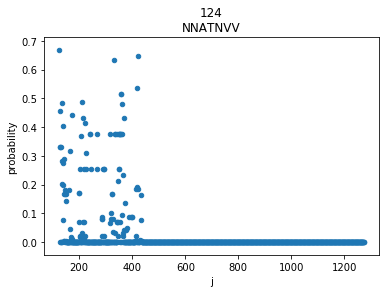

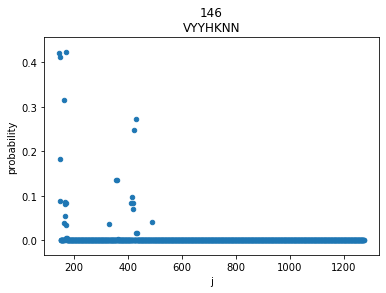

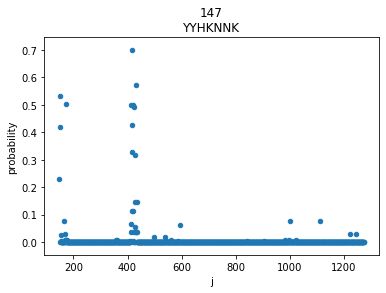

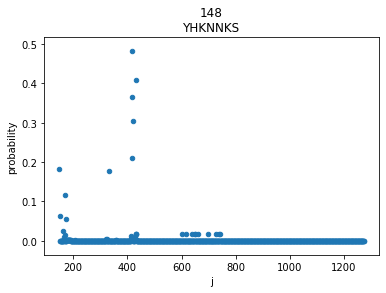

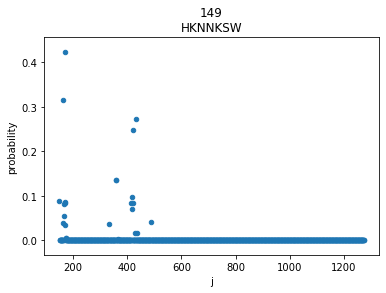

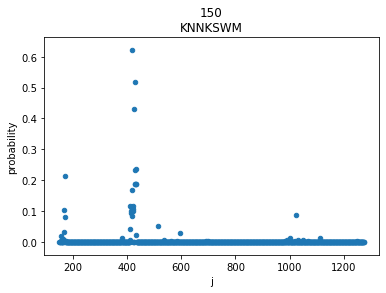

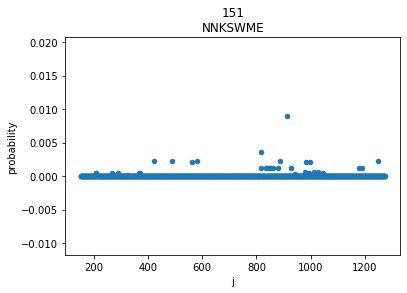

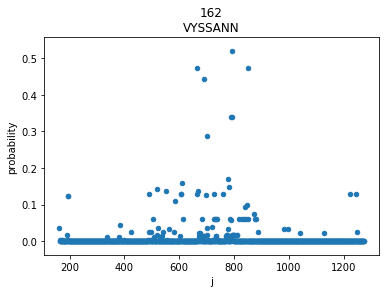

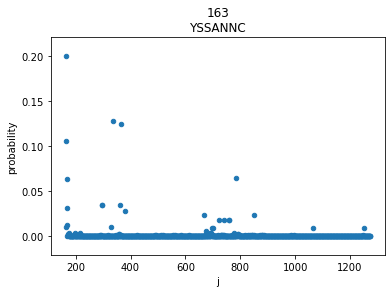

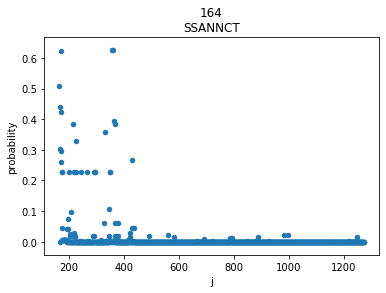

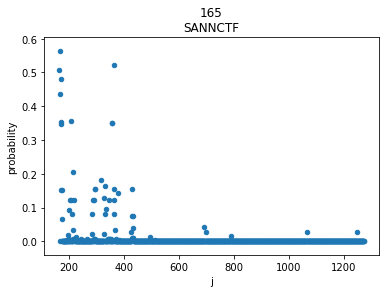

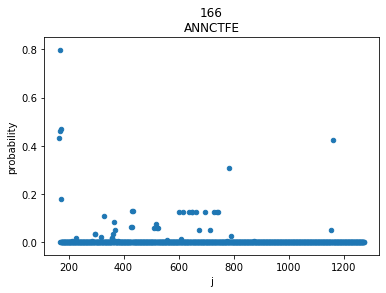

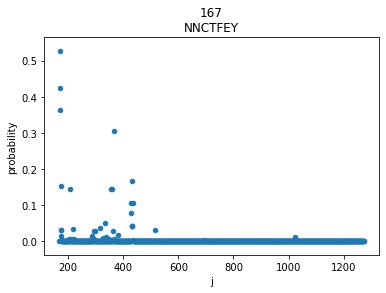

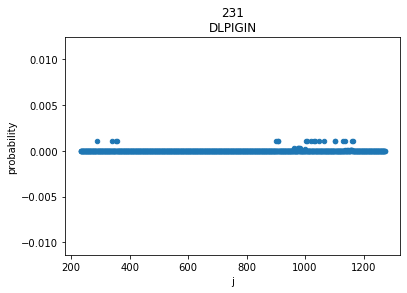

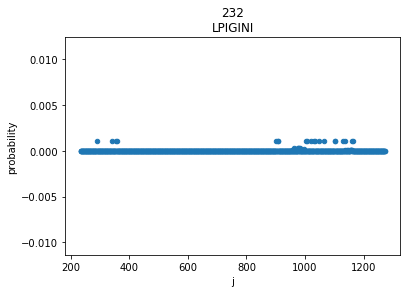

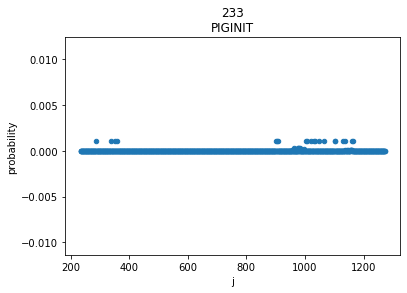

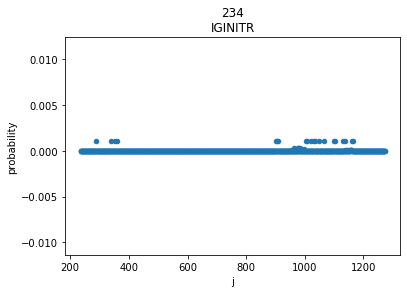

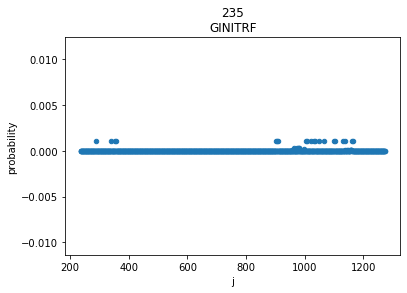

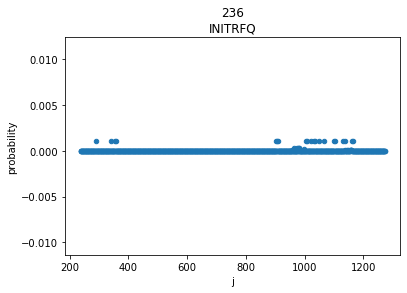

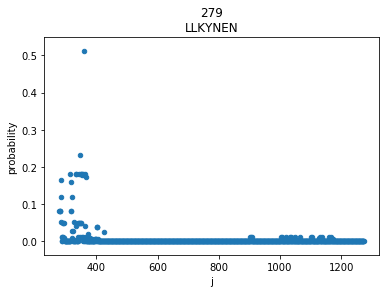

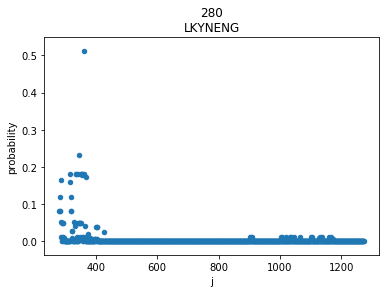

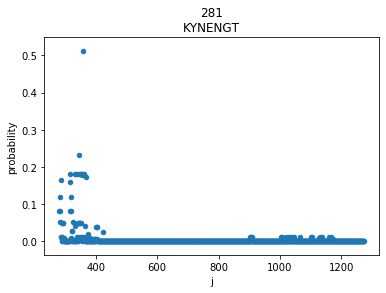

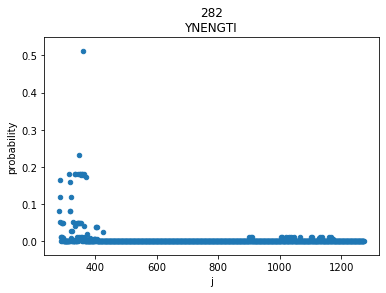

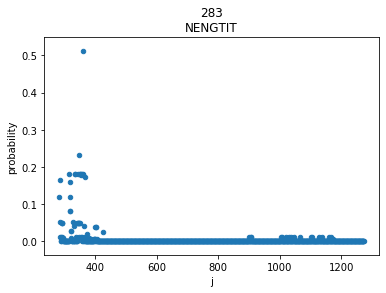

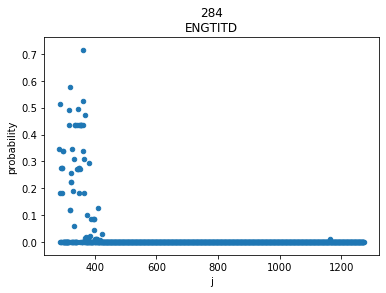

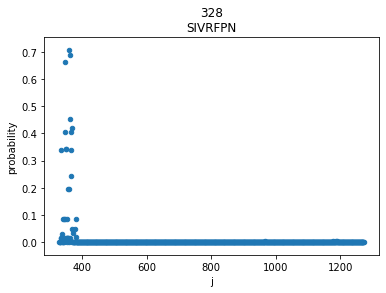

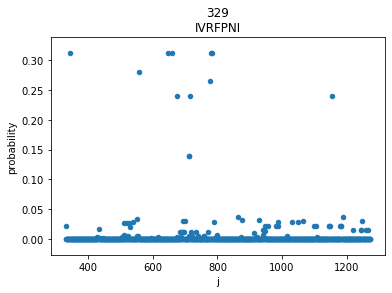

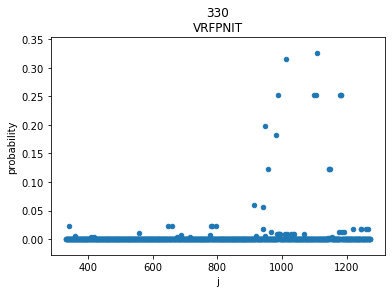

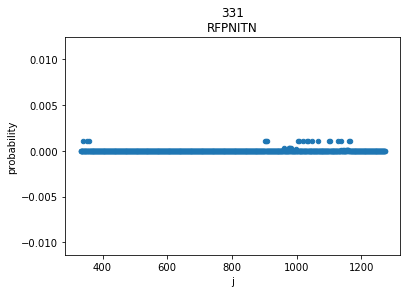

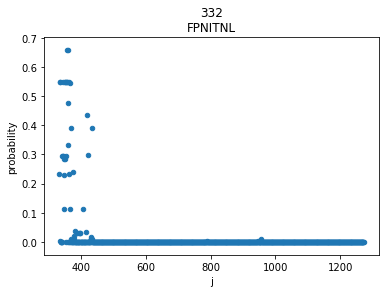

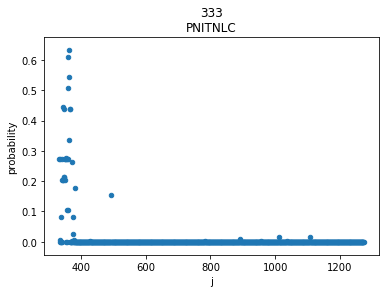

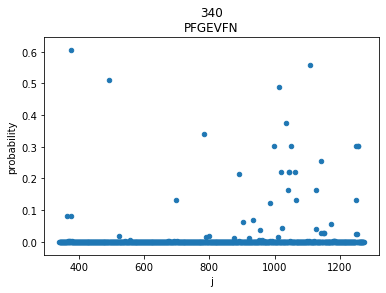

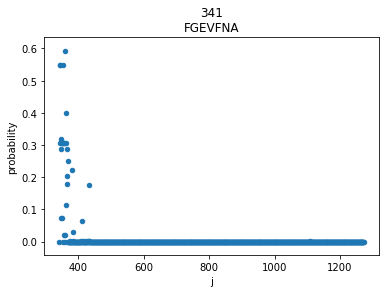

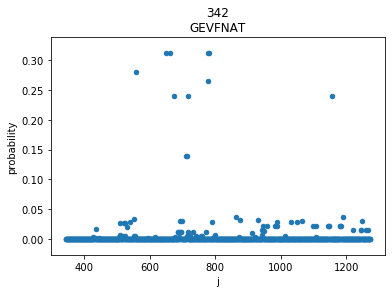

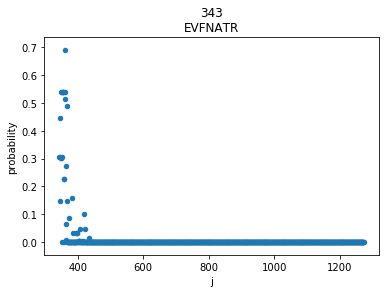

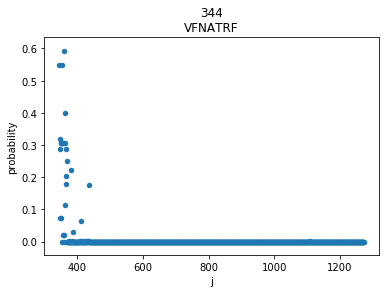

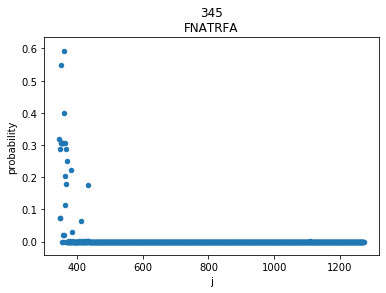

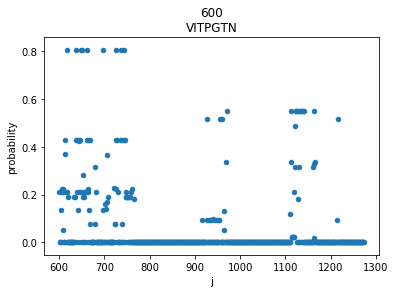

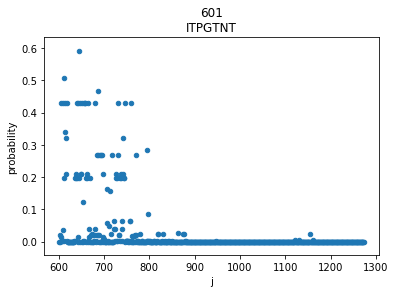

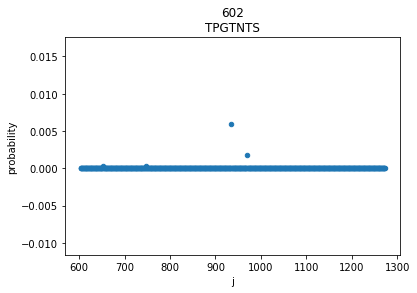

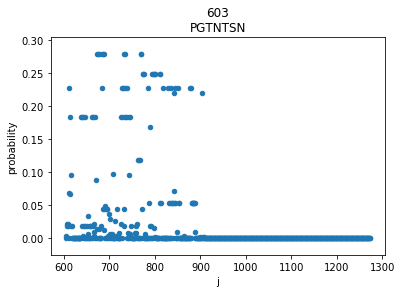

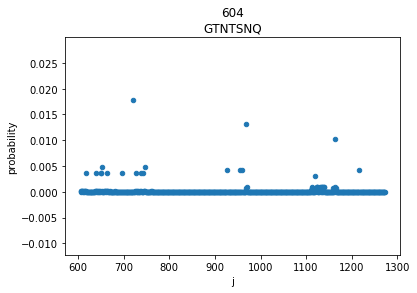

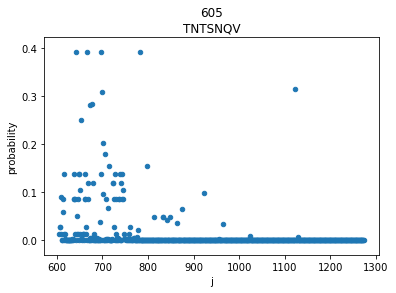

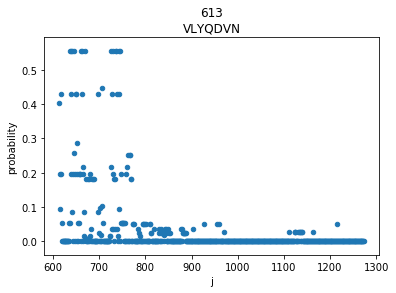

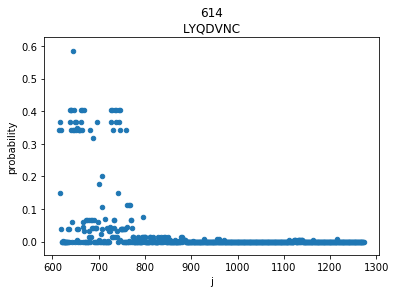

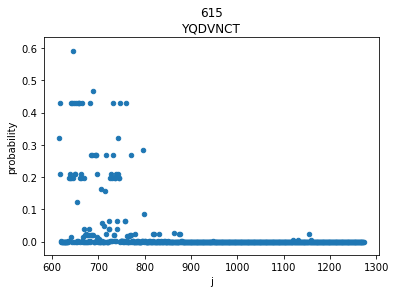

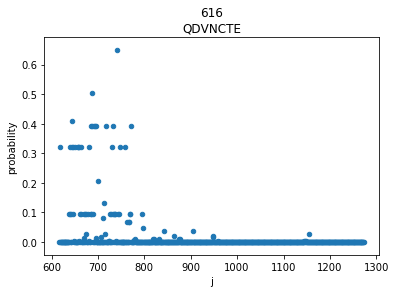

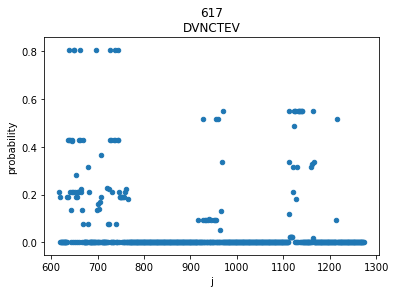

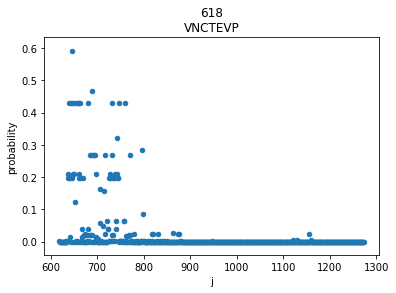

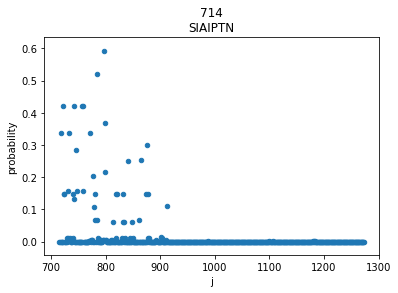

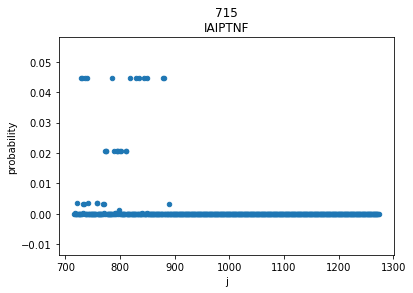

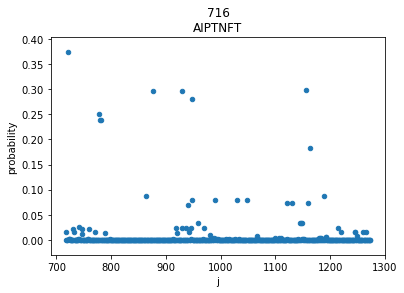

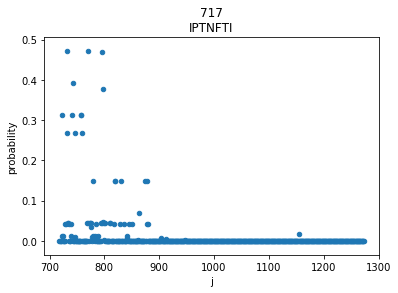

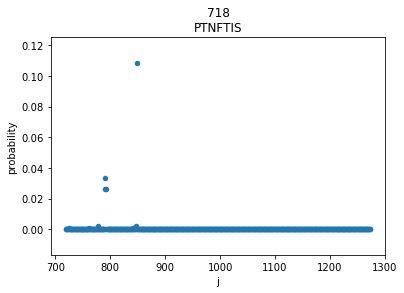

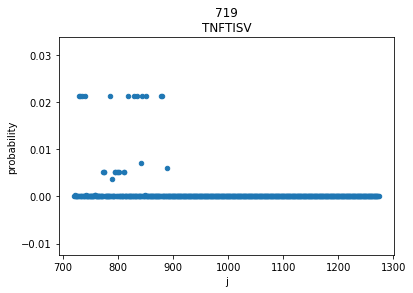

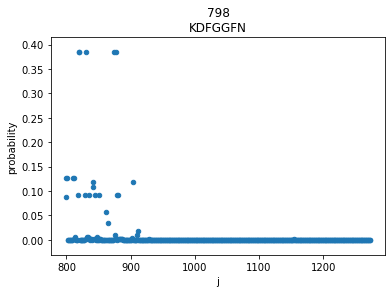

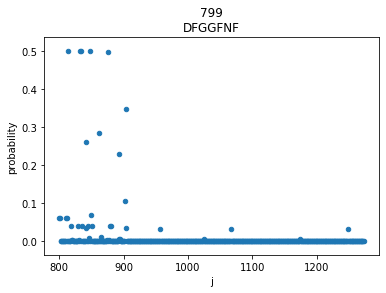

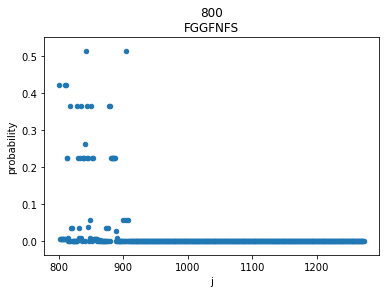

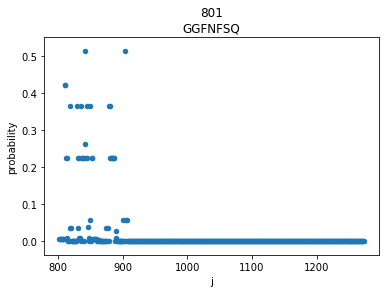

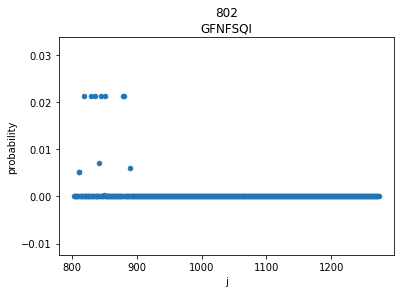

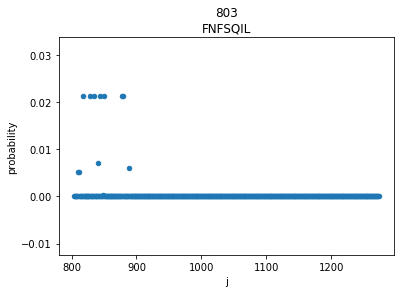

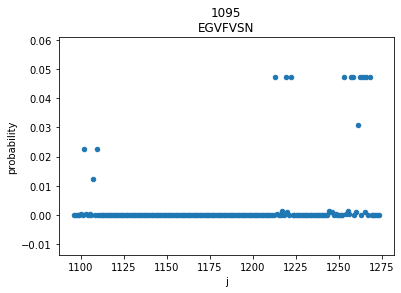

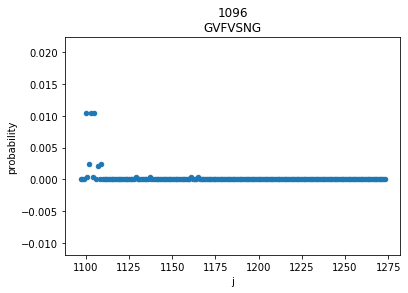

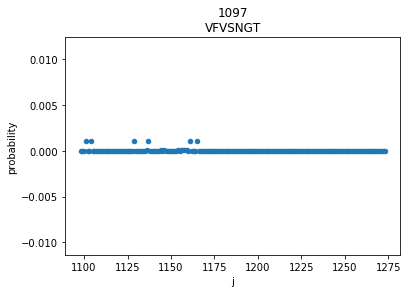

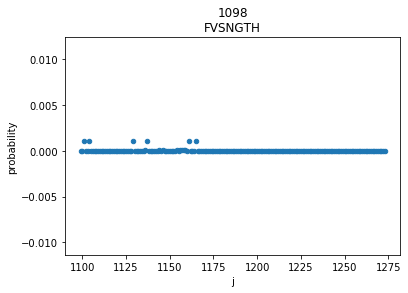

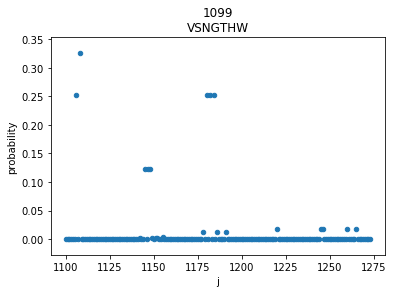

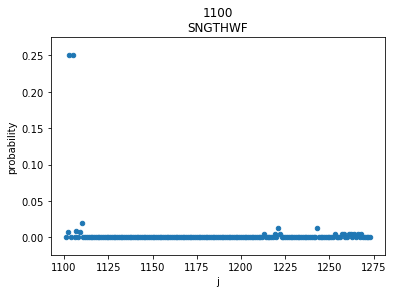

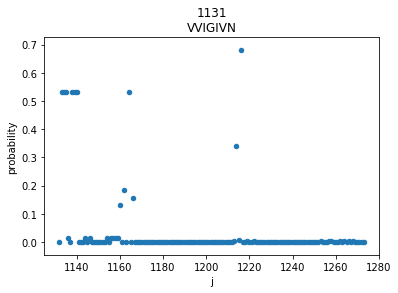

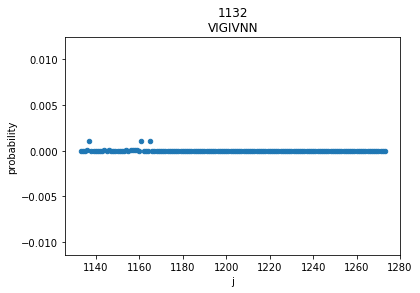

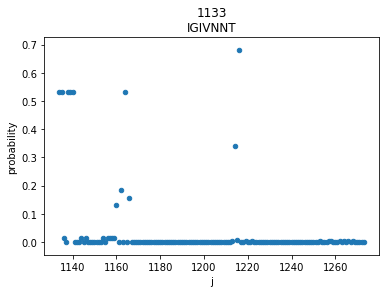

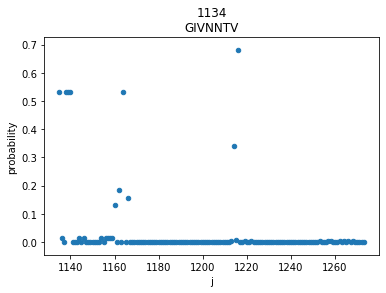

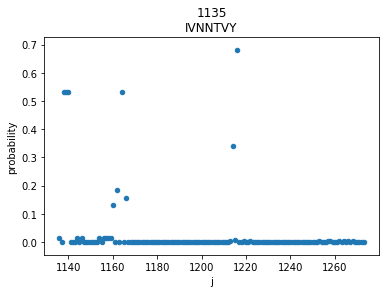

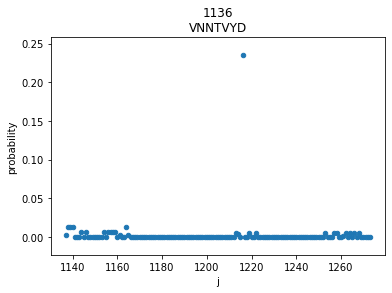

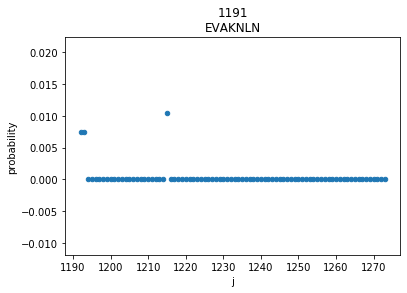

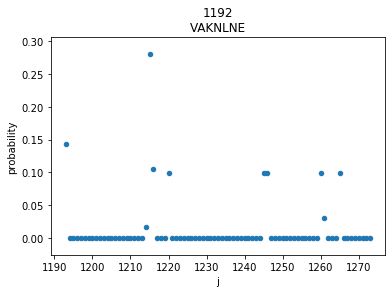

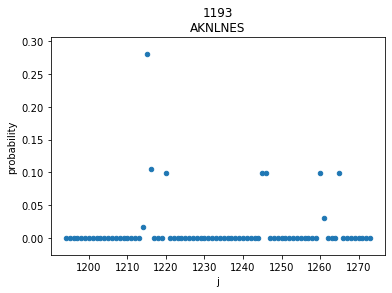

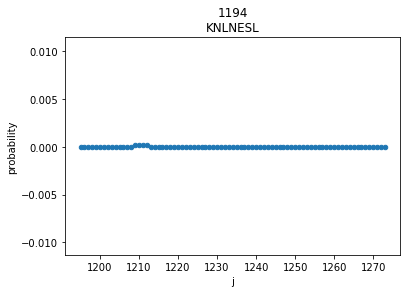

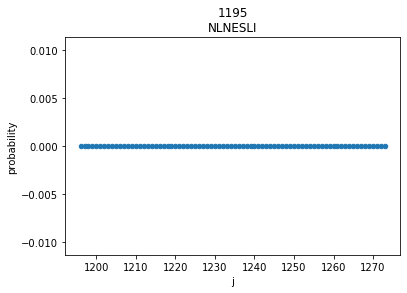

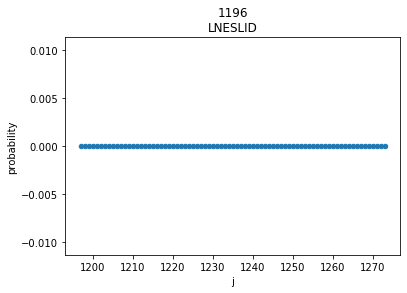

In [79]:
for ind,val in scores[scores["i"].isin(adj_sites)].groupby("i"):
    print("Position", val["i"].values[0])
    val.plot.scatter("j","probability")
    title = "".join(conserved_sequence[int(ind)-1-3 : int(ind)-1+4])
    plt.title(str(ind) + "\n" + title)
    plt.savefig(join(FIGURES_DIR, "P03454_couple_probability_position_" + str(ind)+".png" ))

In [81]:
seqs_msa_a2m = read_msa(join(align_prefix+".a2m"))
glyco_seqs_msa_a2m = seqs_msa_a2m[:,glycosites-1]
adj_seqs_msa_a2m = seqs_msa_a2m[:,np.array(list(adj_sites))-1] 

In [ ]:
df = scores[(scores["i"].isin(adj_sites)) & (scores["j"].isin(adj_sites)) &
            (scores["probability"]>0.7)]
#df = p_05

seqs_msa_a2m = read_msa(os.path.join(align_prefix+".a2m"))


#def pair_conservation_heat(df):
for ind, val in df.iterrows():
    curr_seqs = seqs_msa_a2m[:,[val["i"]-1, val["j"]-1]]
    
    value_to_int = {j:i for i,j in enumerate(pd.unique(curr_seqs.ravel()))} # like you did
    n = len(value_to_int)
    # discrete colormap (n samples from a given cmap)
    if n > 12:
        cmap = sns.color_palette("Paired", 12) + sns.color_palette("cubehelix", n-12)
    else:
        #cmap = sns.color_palette("Pastel2", n)
        cmap = sns.color_palette("Paired", n)

    d = defaultdict(int)
    for i in curr_seqs:
        d[tuple(i)] += 1
        
    i_max = frequencies[frequencies["i"] == val["i"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].argmax()
    j_max = frequencies[frequencies["i"] == val["j"]].drop(["i","A_i","conservation","-"], axis=1).iloc[0].argmax()  

    curr_df = pd.DataFrame(d.keys(), index=d.values(), columns=(i_max + str(val["i"]), j_max
                                                                + str(val["j"])))
    print(d)
    f, ax = plt.subplots(1,1, figsize=(10,10))

    sns.heatmap(curr_df.replace(value_to_int).sort_index(), cmap=cmap,ax=ax, yticklabels=True ) 
    #plt.xticks(rotation='vertical')
    ax.tick_params(axis='y',which='major', labelrotation=0)
    # modify colorbar:
    colorbar = ax.collections[0].colorbar 
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))       
    plt.title(f"Coupled pairs and the sequences\nY label is how many times that pair is seen\nprob={val['probability']}")
    plt.savefig(os.path.join(FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".png")
    plt.savefig(os.path.join(FIGURES_DIR,str(val['i']) + "_" + str(val['j']))+".pdf")
    #break
df


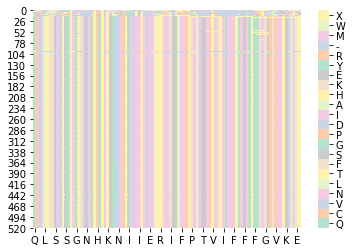

In [82]:
value_to_int = {j:i for i,j in enumerate(pd.unique(adj_seqs_msa_a2m.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(pd.DataFrame(adj_seqs_msa_a2m, 
                              columns=frequencies[frequencies["i"].isin(adj_sites)]["A_i"].values).replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.show()

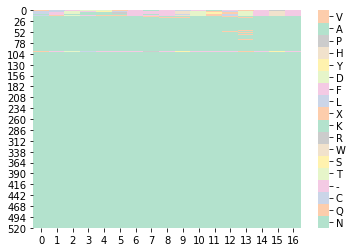

In [83]:
value_to_int = {j:i for i,j in enumerate(pd.unique(glyco_seqs_msa_a2m.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(pd.DataFrame(glyco_seqs_msa_a2m).replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.show()